# OpenAI Gym Cartpole
## Solved using Q learning and neural networks

#### References
Inspiration for this project:
- https://towardsdatascience.com/reinforcement-learning-q-learning-with-decision-trees-ecb1215d9131
- https://www.semanticscholar.org/paper/Reinforcement-Learning-with-Decision-Trees-Pyeatt/f9b30e1f6d85cb77e95ff1d580ee67d7406f1dd6?p2df

Github Repo solving OpenAI cartpole using the same method:
- https://github.com/gsurma/cartpole

In [163]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
from collections import deque
import random
import timeit

In [164]:
class NNpredictor():
    
    #init model and hyperparameters
    def __init__(self,input_shape,output_shape,env,exploration_min = 0.01, exploration_decay = 0.996,
                 exploration_rate = 1, batch_size = 32, gamma = 0.95, lr=0.001):
        self.env = env
        
        #models hyperparameters
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.exploration_rate = exploration_rate
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        
        #model architecture
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_shape,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,output_shape),
        )
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        self.memory = deque(maxlen=1000000)
        
        
    #select an action, either random or from model
    def select_action(self,state):
        #this ensures that the model explores the environment and accumulates memory (stochasticity)
        if np.random.rand() < self.exploration_rate:
            return self.env.action_space.sample()
        
        state = torch.from_numpy(state.astype("float32")) 
        q_values = self.model(state)
        return torch.argmax(q_values).item()


    #add an experience to the model's memory
    def remember(self,last_state,action,reward,next_state,done):
        self.memory.append((last_state,action,reward,next_state,done))

        
    #replay experiences from memory and fit the model
    def experience_replay(self,logs,episode):

        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory,self.batch_size)

        running_loss = 0
        for last_state, action, reward, next_state, done in batch:
            q_update = reward
            if not done:
                #calculate what q value should have been for selected action
                q_update = (reward + self.gamma * torch.amax(self.model(torch.from_numpy(next_state.astype("float32")))).item())
            q_values = self.model(torch.from_numpy(last_state.astype("float32")))
            q_values[action] = q_update

            #fit
            l = self.loss(self.model(torch.from_numpy(last_state.astype("float32"))), q_values)
            self.model.zero_grad()
            l.backward()
            self.optimizer.step()
            running_loss += l.item()
        
        try:
            logs.episodes_loss[episode-1] += running_loss/self.batch_size
        except IndexError:
            logs.episodes_loss = np.append(logs.episodes_loss,running_loss/self.batch_size)

        #decay exploration rate to reduce randomness
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [121]:
class MetricsLogger():
    
    def __init__(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])
        self.episodes_loss = np.array([])
        self.runs_logs = np.empty((0,4))
        
    def reset_run(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])
        self.episodes_loss = np.array([])

In [122]:
#Init environment
env = gym.make('CartPole-v0')
env._max_episode_steps = 200

#Init Logger
logs = MetricsLogger()

In [123]:
################################
# Training loop #
################################

for run_i in range(5):
    start = timeit.default_timer()
    num_solved = 0
    episode_i = 0
    episode_i_before_solve = 0
    logs.reset_run()
    
    #Init model
    model = NNpredictor(4,2,env)
    
    while num_solved < 5 and episode_i < 2000:

        episode_i += 1
        last_state = env.reset()
        steps = 0
        total_reward = 0
        episode_i_before_solve += 1

        while True:
            running_loss = 0
            #uncomment this to display simulation 
    #         env.render()
            steps += 1
            action = model.select_action(last_state)
            next_state, reward, done, info = env.step(action)
            reward = reward if not done else -reward
            model.remember(last_state,action,reward,next_state,done)
            model.experience_replay(logs,episode_i)

            total_reward += reward

            if done:
                print("Episode {} finished after {} steps with {} total reward".format(episode_i,steps,total_reward))
                if total_reward > 190:
                    logs.episodes_before_solve = np.append(logs.episodes_before_solve,episode_i_before_solve)
                    episode_i_before_solve = 0
                    num_solved += 1
                break

            last_state = next_state

        logs.episodes_steps = np.append(logs.episodes_steps,steps)

    stop = timeit.default_timer()
    print("Run {} done in {}".format(run_i,stop - start))
    
    logs.runs_logs = np.append(logs.runs_logs,[[logs.episodes_steps,logs.episodes_before_solve,logs.episodes_loss,stop - start]],axis=0)
    
env.close()

Episode 1 finished after 23 steps with 21.0 total reward
Episode 2 finished after 16 steps with 14.0 total reward
Episode 3 finished after 19 steps with 17.0 total reward
Episode 4 finished after 21 steps with 19.0 total reward
Episode 5 finished after 31 steps with 29.0 total reward
Episode 6 finished after 18 steps with 16.0 total reward
Episode 7 finished after 15 steps with 13.0 total reward
Episode 8 finished after 17 steps with 15.0 total reward
Episode 9 finished after 14 steps with 12.0 total reward
Episode 10 finished after 12 steps with 10.0 total reward
Episode 11 finished after 13 steps with 11.0 total reward
Episode 12 finished after 13 steps with 11.0 total reward
Episode 13 finished after 12 steps with 10.0 total reward
Episode 14 finished after 11 steps with 9.0 total reward
Episode 15 finished after 15 steps with 13.0 total reward
Episode 16 finished after 10 steps with 8.0 total reward
Episode 17 finished after 11 steps with 9.0 total reward
Episode 18 finished after 

Episode 143 finished after 121 steps with 119.0 total reward
Episode 144 finished after 151 steps with 149.0 total reward
Episode 145 finished after 134 steps with 132.0 total reward
Episode 146 finished after 148 steps with 146.0 total reward
Episode 147 finished after 190 steps with 188.0 total reward
Episode 148 finished after 164 steps with 162.0 total reward
Episode 149 finished after 155 steps with 153.0 total reward
Episode 150 finished after 200 steps with 198.0 total reward
Episode 151 finished after 200 steps with 198.0 total reward
Run 0 done in 234.90462549999938
Episode 1 finished after 16 steps with 14.0 total reward
Episode 2 finished after 19 steps with 17.0 total reward
Episode 3 finished after 16 steps with 14.0 total reward
Episode 4 finished after 21 steps with 19.0 total reward
Episode 5 finished after 19 steps with 17.0 total reward
Episode 6 finished after 13 steps with 11.0 total reward
Episode 7 finished after 12 steps with 10.0 total reward
Episode 8 finished 

Episode 27 finished after 66 steps with 64.0 total reward
Episode 28 finished after 105 steps with 103.0 total reward
Episode 29 finished after 134 steps with 132.0 total reward
Episode 30 finished after 80 steps with 78.0 total reward
Episode 31 finished after 104 steps with 102.0 total reward
Episode 32 finished after 125 steps with 123.0 total reward
Episode 33 finished after 200 steps with 198.0 total reward
Episode 34 finished after 160 steps with 158.0 total reward
Episode 35 finished after 174 steps with 172.0 total reward
Episode 36 finished after 131 steps with 129.0 total reward
Episode 37 finished after 128 steps with 126.0 total reward
Episode 38 finished after 180 steps with 178.0 total reward
Episode 39 finished after 153 steps with 151.0 total reward
Episode 40 finished after 158 steps with 156.0 total reward
Episode 41 finished after 162 steps with 160.0 total reward
Episode 42 finished after 142 steps with 140.0 total reward
Episode 43 finished after 178 steps with 176

Episode 87 finished after 173 steps with 171.0 total reward
Episode 88 finished after 200 steps with 198.0 total reward
Run 4 done in 180.600248799994


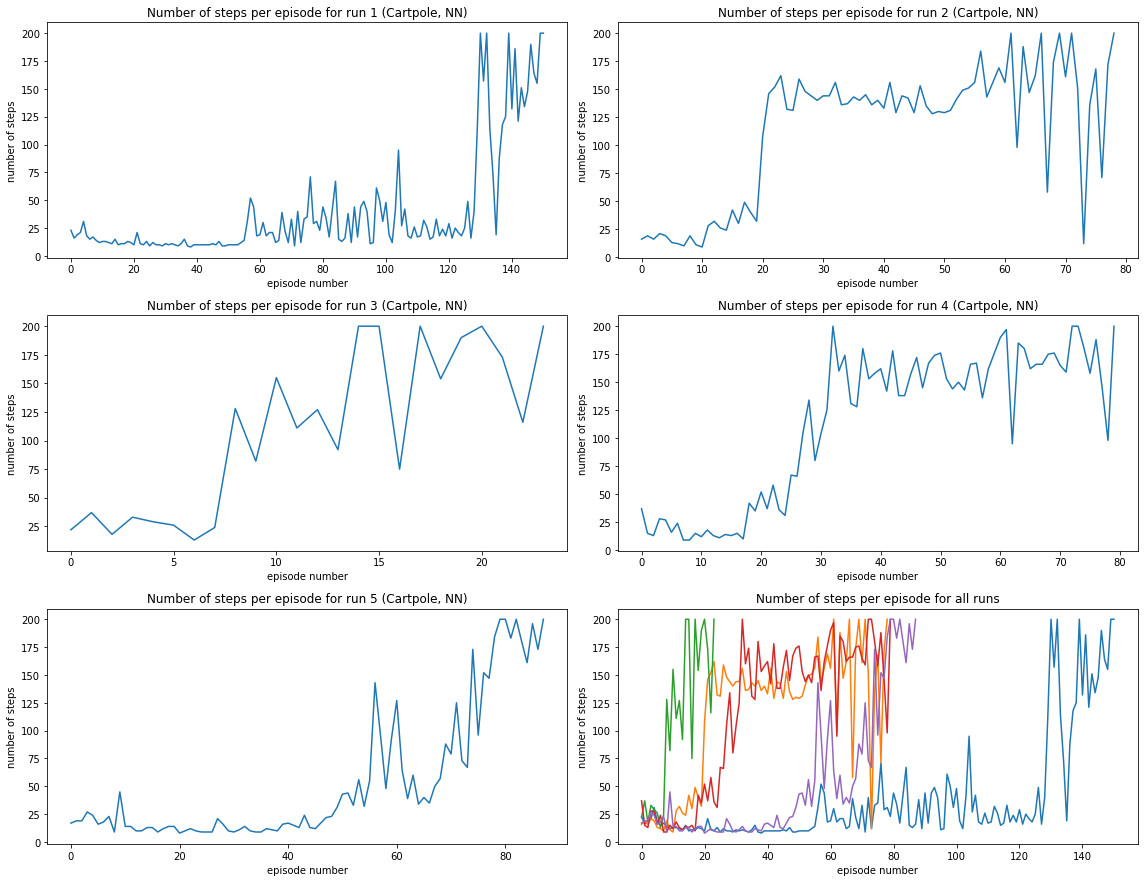

In [169]:
plt.figure(figsize=(16,16))
count = 0
for run_log in logs.runs_logs:
    count += 1
    plt.subplot(4,2,count,title="Number of steps per episode for run {} (Cartpole, NN)".format(count))
    plt.plot(run_log[0])
    plt.xlabel("episode number")
    plt.ylabel("number of steps")
    
plt.subplot(4,2,count+1,title="Number of steps per episode for all runs")
for run_log in logs.runs_logs:
    plt.plot(run_log[0])
plt.xlabel("episode number")
plt.ylabel("number of steps")
    
plt.tight_layout()
plt.show;


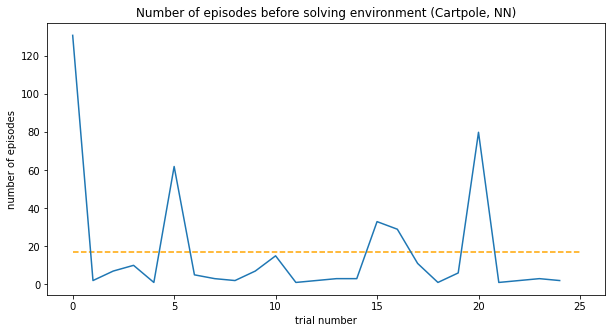

In [170]:
#####
# Everytime the env is solved, we look at the number of episodes it took before solving it.
# The peaks are at the start of each run, since the model is not yet trained.
####
cumul_episodes_before_solve = np.array([])
for run_log in logs.runs_logs:
    cumul_episodes_before_solve = np.append(cumul_episodes_before_solve,run_log[1])

average_episiodes_before_solve = np.sum(cumul_episodes_before_solve)/len(cumul_episodes_before_solve)

plt.figure(figsize=(10,5))
plt.plot(cumul_episodes_before_solve)
plt.hlines(average_episiodes_before_solve,0,25,linestyles="dashed",colors="orange")
plt.title("Number of episodes before solving environment (Cartpole, NN)")
plt.xlabel("trial number")
plt.ylabel("number of episodes")
plt.show;

In [172]:
cumul_steps_per_eps = np.array([])
cumul_time_per_run = np.array([])
for run_log in logs.runs_logs:
    cumul_steps_per_eps = np.append(cumul_steps_per_eps,run_log[0])
    cumul_time_per_run = np.append(cumul_time_per_run,run_log[3])

print("\nTotal number of steps per run:")
run_count = 0
for run_log in logs.runs_logs:
    run_count += 1
    print("\tRun {}, total steps : {}".format(run_count,np.sum(run_log[0])))
    
print("\nAverage episodes before solve: {}".format(average_episiodes_before_solve))

print("\nTotal number of steps: {}".format(np.sum(cumul_steps_per_eps)))
print("Average number of steps per run: {}".format(np.sum(cumul_steps_per_eps)/5))
print("\nAverage time per run: {} seconds".format(np.sum(cumul_time_per_run)/5))
print("Average time per step: {:.2f} seconds".format(np.sum(cumul_steps_per_eps)/np.sum(cumul_time_per_run)))


Total number of steps per run:
	Run 1, total steps : 6009.0
	Run 2, total steps : 9053.0
	Run 3, total steps : 2605.0
	Run 4, total steps : 9087.0
	Run 5, total steps : 4777.0

Average episodes before solve: 16.88

Total number of steps: 31531.0
Average number of steps per run: 6306.2

Average time per run: 243.03477917999552 seconds
Average time per step: 25.95 seconds
